# Masks to annotations workflow

**Overview:**

This includes two key functionalities:

- Parsing annotatoins from a groung truth mask into contours (pandas dataframe)

- Parsing contours into a format that is compatible with large_image annotation schema and
ready to push for visualization in Digital Slide Archive HistomicsTK. 


This extends on some of the workflows described in Amgad et al, 2019:

__Mohamed Amgad, Habiba Elfandy, Hagar Hussein, ..., Jonathan Beezley, Deepak R Chittajallu, David Manthey, David A Gutman, Lee A D Cooper, Structured crowdsourcing enables convolutional segmentation of histology images, Bioinformatics, 2019, btz083__


This slide used as a test example:

[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d586d76bd4404c6b1f286ae&bounds=54743%2C32609%2C68828%2C39395%2C0 )

**Where to look?**

```
|_ histomicstk/
|   |
|   |_annotations_and_masks/
|      |_masks_to_annotations_handler.py 
|
|_ plugin_tests/
    |
    |_annotations_and_masks/
    |  |_ masks_to_annotations_handler_test.py
    |
    |_test_files/
       |_sample_GTcodes.csv 
       |_TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39_left-59206_top-33505_mag-BASE.png
       |_sample_contours_df.tsv 
```

In [1]:
from __future__ import print_function

import os
import sys
CWD = os.getcwd()
sys.path.append(os.path.join(CWD, '..', '..'))

import girder_client
from pandas import read_csv
from imageio import imread
from masks_to_annotations_handler import (
    get_contours_from_bin_mask, get_contours_from_mask,
    get_single_annotation_document_from_contours, get_annotation_documents_from_contours)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 7, 7

## 1. Constants & prep work

In [2]:
# APIURL = 'http://demo.kitware.com/histomicstk/api/v1/'
# SAMPLE_SLIDE_ID = '5bbdee92e629140048d01b5d'
APIURL = 'http://candygram.neurology.emory.edu:8080/api/v1/'
SAMPLE_SLIDE_ID = '5d586d76bd4404c6b1f286ae'

# Connect to girder client
gc = girder_client.GirderClient(apiUrl=APIURL)
# gc.authenticate(interactive=True)
gc.authenticate(apiKey='kri19nTIGOkWH01TbzRqfohaaDWb6kPecRqGmemb')

### Let's inspect the ground truth codes file

This contains the ground truth codes and information dataframe. This is a dataframe that is indexed by the annotation group name and has the following columns:

- ``group``: group name of annotation (string), eg. "mostly_tumor"
- ``GT_code``: int, desired ground truth code (in the mask) Pixels of this value belong to corresponding group (class)
- ``color``: str, rgb format. eg. rgb(255,0,0).

__IMPORTANT NOTE:__

Zero pixels have special meaning and do NOT encode specific ground truth class. Instead, they simply mean 'Outside ROI' and should be IGNORED during model training or evaluation.

In [3]:
# read GTCodes dataframe
GTCODE_PATH = os.path.join(
    CWD, '..', '..', 'plugin_tests', 'test_files', 'sample_GTcodes.csv')
GTCodes_df = read_csv(GTCODE_PATH)
GTCodes_df.index = GTCodes_df.loc[:, 'group']

In [4]:
GTCodes_df.head()

,group,overlay_order,GT_code,is_roi,is_background_class,color,comments
group,,,,,,,
roi,roi,0,255,1,0,"rgb(200,0,150)",NaN
evaluation_roi,evaluation_roi,0,254,1,0,"rgb(255,0,0)",NaN
mostly_tumor,mostly_tumor,1,1,0,0,"rgb(255,0,0)",core class
mostly_stroma,mostly_stroma,2,2,0,1,"rgb(255,125,0)",core class
mostly_lymphocytic_infiltrate,mostly_lymphocytic_infiltrate,1,3,0,0,"rgb(0,0,255)",core class


### Read and visualize mask

In [5]:
# read mask
X_OFFSET = 59206
Y_OFFSET = 33505
MASKNAME = "TCGA-A2-A0YE-01Z-00-DX1.8A2E3094-5755-42BC-969D-7F0A2ECA0F39" + \
    "_left-%d_top-%d_mag-BASE.png" % (X_OFFSET, Y_OFFSET)
MASKPATH = os.path.join(CWD, '..', '..', 'plugin_tests', 'test_files', MASKNAME)
MASK = imread(MASKPATH)

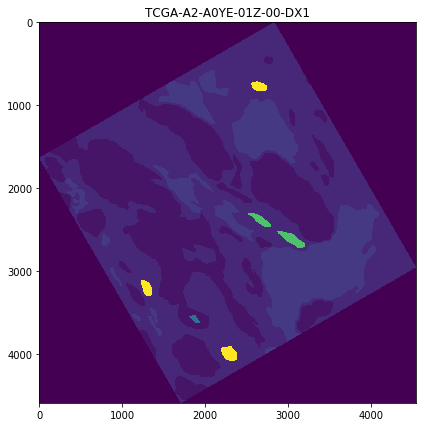

In [6]:
plt.figure(figsize=(7,7))
plt.imshow(MASK)
plt.title(MASKNAME[:23])
plt.show()

## 2. Get contours from mask

### This is the core method you want to look at

In [7]:
print(get_contours_from_mask.__doc__)

Parse ground truth mask and gets countours for annotations.

    Parameters
    -----------
    MASK : nd array
        ground truth mask (m,n) where pixel values encode group membership.
    GTCodes_df : pandas Dataframe
        the ground truth codes and information dataframe.
        This is a dataframe that is indexed by the annotation group name and
        has the following columns.

        group: str
            group name of annotation, eg. mostly_tumor.
        GT_code: int
            desired ground truth code (in the mask). Pixels of this value
            belong to corresponding group (class).
        color: str
            rgb format. eg. rgb(255,0,0).
    groups_to_get : None
        if None (default) then all groups (ground truth labels) will be
        extracted. Otherwise pass a list fo strings like ['mostly_tumor',].
    MIN_SIZE : int
        minimum bounding box size of contour
    MAX_SIZE : None
        if not None, int. Maximum bounding box size of contour. Some

As you can see, there are many parameters that you can set, but don't worry, most parameters have sensible defaults in case you get confused. The only require parameters are ``MASK`` and ``GTCodes_df``, but you may want to consider setting the following parameters based on your specific needs: ``get_roi_contour``, ``roi_group``, ``discard_nonenclosed_background``, ``background_group``, which control the method's behaviour regarding region of interest (ROI) boundary and background pixel class (eg stroma).

### Extract contours

In [8]:
# Let's extract all contours from a mask, including ROI boundary. We will
# be discarding any stromal contours that are not fully enclosed within a 
# non-stromal contour since we already know that stroma is the background
# group. This is so things look uncluttered when posted to DSA.
groups_to_get = None
contours_df = get_contours_from_mask(
    MASK=MASK, GTCodes_df=GTCodes_df, groups_to_get=groups_to_get,
    get_roi_contour=True, roi_group='roi',
    discard_nonenclosed_background=True,
    background_group='mostly_stroma',
    MIN_SIZE=30, MAX_SIZE=None, verbose=True,
    monitorPrefix=MASKNAME[:12] + ": getting contours")

TCGA-A2-A0YE: getting contours: non-roi: roi: NO OBJECTS!!
TCGA-A2-A0YE: getting contours: non-roi: evaluation_roi: NO OBJECTS!!
TCGA-A2-A0YE: getting contours: non-roi: mostly_tumor: getting contours
TCGA-A2-A0YE: getting contours: non-roi: mostly_tumor: adding contours
TCGA-A2-A0YE: getting contours: non-roi: mostly_stroma: getting contours
TCGA-A2-A0YE: getting contours: non-roi: mostly_stroma: adding contours
TCGA-A2-A0YE: getting contours: non-roi: nest 1 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 2 of 11: TOO SIMPLE (2 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 3 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 4 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 5 of 11: TOO SMALL (10 x 18 pixels) -- IGNORED
TCGA-A2-A0YE: getting contours: non-roi: nest 6 of 11: TOO SIMPLE (1 coordinates) -- IGNORED
TCGA-A2-A0YE: getting con

### Let's inspect the resultant contours dataframe

The columns that really matter here are ``group``, ``color``, ``coords_x``, and ``coords_y``.

In [9]:
contours_df.head()

,group,color,ymin,ymax,xmin,xmax,has_holes,touches_edge-top,touches_edge-left,touches_edge-bottom,touches_edge-right,coords_x,coords_y
0,roi,"rgb(200,0,150)",0.0,4593.0,0.0,4541.0,0.0,1.0,1.0,1.0,1.0,"2835,2834,2833,2832,2831,2830,2829,2827,2826,2...","0,1,1,2,2,3,3,5,5,6,6,8,8,9,9,10,10,12,12,13,1..."
1,mostly_tumor,"rgb(255,0,0)",4269.0,4560.0,1639.0,2039.0,1.0,0.0,0.0,0.0,0.0,"1673,1672,1668,1667,1662,1661,1659,1658,1658,1...","4269,4270,4270,4271,4271,4272,4272,4273,4274,4..."
2,mostly_tumor,"rgb(255,0,0)",3764.0,4282.0,1607.0,2187.0,0.0,0.0,0.0,0.0,0.0,"1770,1769,1768,1767,1765,1764,1762,1761,1760,1...","3764,3765,3765,3766,3766,3767,3767,3768,3768,3..."
3,mostly_tumor,"rgb(255,0,0)",3712.0,4051.0,1201.0,1411.0,0.0,0.0,0.0,0.0,0.0,"1214,1213,1211,1210,1208,1207,1206,1205,1203,1...","3712,3713,3713,3714,3714,3715,3715,3716,3716,3..."
4,mostly_tumor,"rgb(255,0,0)",3356.0,3748.0,3108.0,3540.0,0.0,0.0,0.0,0.0,0.0,"3342,3341,3337,3336,3332,3331,3328,3327,3326,3...","3356,3357,3357,3358,3358,3359,3359,3360,3360,3..."


## 3. Get annotation documents from contours

### This is the core method you want to look at

In [10]:
print(get_annotation_documents_from_contours.__doc__)

Given dataframe of contours, get list of annotation documents.

    This method parses a dataframe of contours to a list of dictionaries, each
    of which represents and large_image style annotation. This is a wrapper
    that extends the functionality of the method
    get_single_annotation_document_from_contours(), whose docstring should
    be referenced for implementation details and further explanation.

    Parameters
    -----------
    contours_df : pandas DataFrame
        WARNING - This is modified inside the function, so pass a copy.
        This dataframe includes data on contours extracted from input mask
        using get_contours_from_mask(). If you have contours using some other
        method, just make sure the dataframe follows the same schema as the
        output from get_contours_from_mask(). You may find a sample dataframe
        in thie repo at ./plugin_tests/test_files/sample_contours_df.tsv
        The following columns are relevant for this method.

       

As mentioned in the docs, this is a wrapper around ``get_single_annotation_document_from_contours()``, so let's inspect it as well.

In [11]:
print(get_single_annotation_document_from_contours.__doc__)

Given dataframe of contours, get annotation document.

    This uses the large_image annotation schema to create an annotation
    document that maybe posted to DSA for viewing using something like:
    resp = gc.post("/annotation?itemId=" + slide_id, json=annotation_doc)
    The annotation schema can be found at:
    github.com/girder/large_image/blob/master/docs/annotations.md .

    Parameters
    -----------
    contours_df_slice : pandas DataFrame
        The following columns are of relevance and must be contained.

        group : str
            annotation group (ground truth label).
        color : str
            annotation color if it were to be posted to DSA.
        coords_x : str
            vertix x coordinates comma-separated values
        coords_y
            vertix y coordinated comma-separated values
    docname : str
        annotation document name
    F : float
        how much smaller is the mask where the contours come from is relative
        to the slide scan

Let's get a list of annotation documents (each is a dictionary). For the purpose of this tutorial, 
we'll separate the documents by group (i.e. each document is composed of polygons from the same
style/group). You could decide to allow heterogeneous styles in the same annotation document by
setting ``separate_docs_by_group`` to ``False``. We'll group every 10 polygons in the same document
for this demo (any extras are grouped with the last document), but realistically you'd want to 
use a large number, perhapd 200. Don't set it to an extremely large number though (not more than, 
say, 1000) to avoid performance issues when posting these documents or viewing them on DSA.

### Get annotation documents

In [12]:
# get list of annotation documents
annprops = {
    'X_OFFSET': X_OFFSET,
    'Y_OFFSET': Y_OFFSET,
    'opacity': 0.2,
    'lineWidth': 4.0,
}
annotation_docs = get_annotation_documents_from_contours(
    contours_df.copy(), separate_docs_by_group=True, annots_per_doc=10,
    docnamePrefix='demo', annprops=annprops,
    verbose=True, monitorPrefix=MASKNAME[:12] + ": annotation docs")

TCGA-A2-A0YE: annotation docs: normal_acinus_or_duct: doc 1 of 1: contour 1 of 2
TCGA-A2-A0YE: annotation docs: normal_acinus_or_duct: doc 1 of 1: contour 2 of 2
TCGA-A2-A0YE: annotation docs: exclude: doc 1 of 1: contour 1 of 1
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 1 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 2 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 3 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 4 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 5 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 6 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 7 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 8 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 9 of 10
TCGA-A2-A0YE: annotation docs: mostly_tumor: doc 1 of 2: contour 10 of 10
TCGA-A2-A0YE: annotation docs: mostly_tu

### Let's inspect one of the documents. 

We'll limit to first two elements (polygons) and we'll limit the vertices to first
couple to be able to see it clearly.

In [13]:
ann_doc = annotation_docs[0].copy()
ann_doc['elements'] = ann_doc['elements'][:2]
for i in range(2):
    ann_doc['elements'][i]['points'] = ann_doc['elements'][i]['points'][:5]

In [14]:
ann_doc

{'description': '',
 'elements': [{'closed': True,
   'fillColor': 'rgba(0,255,0,0.2)',
   'group': 'normal_acinus_or_duct',
   'label': {'value': 'normal_acinus_or_duct'},
   'lineColor': 'rgb(0,255,0)',
   'lineWidth': 4.0,
   'points': [[62081.0, 36019.0, 0.0],
    [62081.0, 36021.0, 0.0],
    [62080.0, 36022.0, 0.0],
    [62080.0, 36025.0, 0.0],
    [62079.0, 36026.0, 0.0]],
   'type': 'polyline'},
  {'closed': True,
   'fillColor': 'rgba(0,255,0,0.2)',
   'group': 'normal_acinus_or_duct',
   'label': {'value': 'normal_acinus_or_duct'},
   'lineColor': 'rgb(0,255,0)',
   'lineWidth': 4.0,
   'points': [[61743.0, 35806.0, 0.0],
    [61742.0, 35807.0, 0.0],
    [61741.0, 35807.0, 0.0],
    [61740.0, 35808.0, 0.0],
    [61738.0, 35808.0, 0.0]],
   'type': 'polyline'}],
 'name': 'demo_normal_acinus_or_duct-0'}

### Now we post it to DSA HistomicsTK slide

In [15]:
# deleting existing annotations in target slide (if any)
existing_annotations = gc.get('/annotation/item/' + SAMPLE_SLIDE_ID)
for ann in existing_annotations:
    gc.delete('/annotation/%s' % ann['_id'])

# post the annotation documents you created    
for annotation_doc in annotation_docs:
    resp = gc.post(
        "/annotation?itemId=" + SAMPLE_SLIDE_ID, json=annotation_doc)

Now you can go to:
    
[TCGA-A2-A0YE-01Z-00-DX1](http://candygram.neurology.emory.edu:8080/histomicstk#?image=5d586d76bd4404c6b1f286ae&bounds=54743%2C32609%2C68828%2C39395%2C0 )

and confirm that the posted annotations make sense and correspond to tissue boundaries and expected labels.

## 4. [EXTRA] - Explore some of the inner workings

### Core method being called to get contours from binary mask

This relies on ``opencv`` and gets contours from a binary mask and their hierarchy. 

In [16]:
print(get_contours_from_bin_mask.__doc__)

Given a binary mask, get opencv contours.

    Parameters
    -----------
    bin_mask : nd array
        ground truth mask (m,n) - int32 with [0, 1] values.

    Returns
    --------
    dict
        a dictionary with the following keys:
            contour group - the actual contour x,y coordinates.
            heirarchy - contour hierarchy. This contains information about
                how contours relate to each other, in the form:
                [Next, Previous, First_Child, Parent,
                index_relative_to_contour_group]
                The last column is added for convenience and is not part of the
                original opencv output.
            outer_contours - index of contours that do not have a parent, and
                are therefore the outermost most contours. These may have
                children (holes), however.
        See docs.opencv.org/3.1.0/d9/d8b/tutorial_py_contours_hierarchy.html
        for more information.

    
